In [114]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from ignite.metrics import SSIM
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torchvision import models
from torch.nn.functional import relu

## Define the network architecture

In [115]:

# Define the U-Net architecture with a dense layer in the middle
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.bnu1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.bnu2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.bnu3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.bnu4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 28x28x1024
        self.bne5 = nn.BatchNorm2d(512)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bnu1 = nn.BatchNorm2d(2*512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bnu2 = nn.BatchNorm2d(2*256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bnu3 = nn.BatchNorm2d(2*128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bnu4 = nn.BatchNorm2d(2*64)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(n_class)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        #xe41 = relu(self.e41(xp3))
        #xe42 = relu(self.e42(xe41))
        #xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp3))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        #xu1 = self.upconv1(xe52)
        #xu11 = torch.cat([xu1, xe42], dim=1)
        #xd11 = relu(self.d11(xu11))
        #xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xe52)
        
        xu22 = torch.cat([xu2, xe32], dim=1)
        xu22 = self.bnu2(xu22)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        
        xu33 = torch.cat([xu3, xe22], dim=1)
        xu33 = self.bnu3(xu33)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xu44 = self.bnu4(xu44)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        out = self.bn1(out)
        out = self.soft(out)

        return out

## Test the net for a randomly generated recon and data (not representative of actual values)

In [116]:
model = UNet(3)
print(model)
recon = np.random.rand(256, 256)
recon = recon.astype('float32')

recon_tensor = torch.from_numpy(recon)
#data_tensor = torch.from_numpy(data)
recon_tensor = recon_tensor.unsqueeze(0)
recon_tensor = recon_tensor.unsqueeze(1)
#data_tensor = data_tensor.unsqueeze(0)

print(torch.Tensor.size(recon_tensor))
#print(torch.Tensor.size(data_tensor))

print(recon_tensor.shape)
print(recon_tensor.dtype)

with torch.no_grad():
    output = model(recon_tensor)

torch.Tensor.size(output)


UNet(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnu1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnu2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnu3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41

torch.Size([1, 3, 256, 256])

## Load data, turn to tensors

In [117]:
# First we create a function which can go back and forth between a one hot encoding
# (size is [N, 3, 256, 256]) and the mask of 0,1,2 of size [N,1,256,256]

def onehot_to_class(input,which_way = 'to', Ndims = 4):
    N_dp = input.shape[0]
    if Ndims == 4:
        if which_way == 'to':
            class_labels = torch.zeros(N_dp, 1, 256, 256, dtype=torch.long)
            mask0 = (input[:,0,:,:] == 1).unsqueeze(1)
            mask1 = (input[:,1,:,:] == 1).unsqueeze(1)
            mask2 = (input[:,2,:,:] == 1).unsqueeze(1)
            class_labels[mask0] = 0  # Channel 1
            class_labels[mask1] = 1  # Channel 2
            class_labels[mask2] = 2  # Channel 3
            return class_labels #[N_dp, 1, 256, 256]
        elif which_way == 'from':
            mask0 = (input == 0).float()
            mask1 = (input == 1).float()
            mask2 = (input == 2).float()
            return torch.cat((mask0, mask1, mask2), dim=1) # Dimensions are [N_dp, 3, 256, 256]
        else:
            print('The second input to onehot_to_mask must be "to" or "from"')
    
    elif Ndims == 3:
        if which_way == 'to':
            class_labels = torch.zeros(256, 256, dtype=torch.long)
            class_labels[input[0] == 1] = 0  # Channel 1
            class_labels[input[1] == 1] = 1  # Channel 2
            class_labels[input[2] == 1] = 2  # Channel 3
            return class_labels # [256, 256]
        elif which_way == 'from':
            mask0 = (input == 0).float()
            mask1 = (input == 1).float()
            mask2 = (input == 2).float()
            return torch.cat((mask0, mask1, mask2), dim=0) # [3, 256, 256]
        else:
            print('The second input to onehot_to_mask must be "to" or "from"')
    else: 
        print('Ndims must be either 4 or 3.')
        return 0


In [118]:
with h5py.File('training_data1.h5', 'r') as hf:
    X_data_np = np.array(hf['measurements'])
    X_recon_np = np.array(hf['sigmas'])
    X_true_np = np.array(hf['sigmas_true'])

# Create one-hot version of X_true_np
X_data = torch.tensor(X_data_np)
X_recon = torch.tensor(X_recon_np)
X_true = torch.tensor(X_true_np)

N_dp = X_true.shape[0]

X_true_onehot = onehot_to_class(X_true,which_way = 'from',Ndims = 4)
    
dataset = TensorDataset(X_recon,X_true_onehot)
# Calculate the number of samples for each split
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)


In [124]:
learning_rate = 0.5
batch_size = 5
num_epochs = 5
validation_every_steps = 500

loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5,momentum=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    for batch_recon, batch_true in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_recon)
        
        # Compute the loss
        loss = loss_func(outputs,batch_true)
        
        # Backpropagation
        loss.backward()
        
        # Update the weights
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 0.7587
Epoch [2/5], Loss: 0.7466
Epoch [3/5], Loss: 0.7348
Epoch [4/5], Loss: 0.7253
Epoch [5/5], Loss: 0.7216


## Now, test the net visually

2


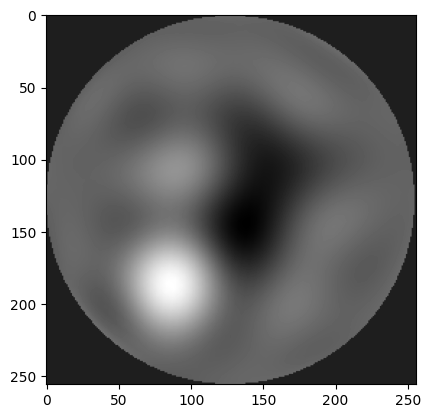

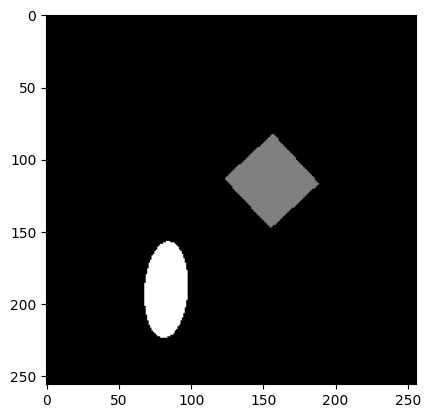

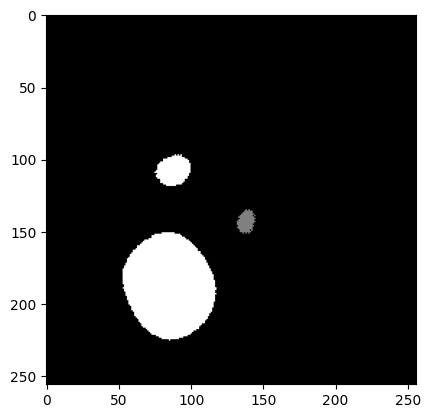

(256, 256)


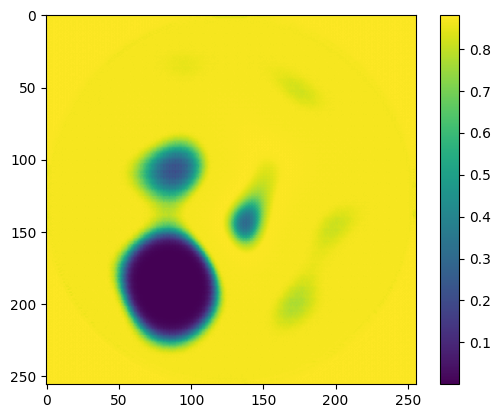

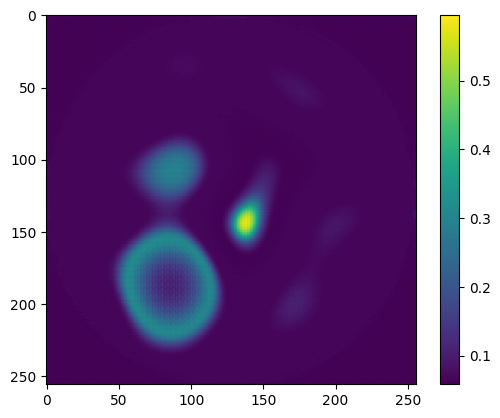

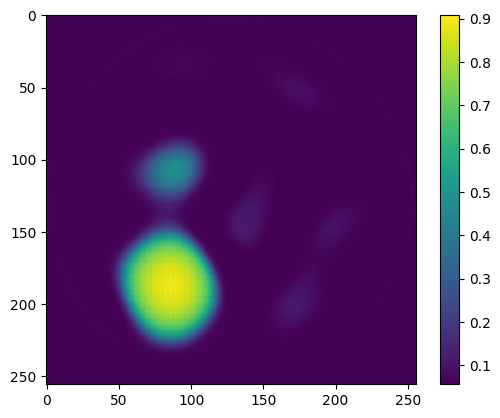

In [133]:
test_data = next(iter(train_dataloader))
sigma = test_data[0][0].numpy().squeeze()
sigma_true_class = torch.argmax(test_data[1],dim=1)[0].numpy()

sigma_model = model(test_data[0])
sigma_model_class = torch.argmax(sigma_model,dim=1)[0].numpy()

torch.argmax(test_data[1],dim=1)
print(np.max(sigma_true_class))

plt.imshow((sigma), cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()
plt.imshow(sigma_true_class, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()
plt.imshow(sigma_model_class, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()
print(sigma_model[0][0].detach().numpy().shape)
plt.imshow(sigma_model[0][0].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(sigma_model[0][1].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(sigma_model[0][2].detach().numpy())
plt.colorbar()
plt.show()

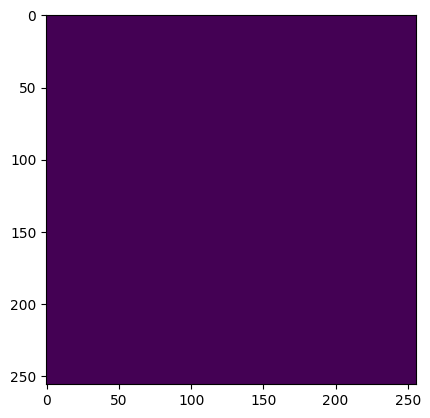

In [18]:
plt.imshow((X_true_np[3][0]) == 3)
X_true_np[3][0][X_true_np[3][0] == 3] = 2

X_true = torch.tensor(X_true_np)

N_dp = X_true.shape[0]

X_true_onehot = onehot_to_class(X_true,which_way = 'from',Ndims = 4)



In [19]:
print(sigma_model.shape)

torch.Size([16, 3, 256, 256])


In [20]:
ssim(X_true, X_true, data_range = 2)

tensor(1.)

In [21]:
ssim = SSIM(data_range = 2, kernel_size = 301, sigma = 80.0, k1 = 1e-4, k2 = 9*1e-4)


TypeError: SSIM.__init__() got an unexpected keyword argument 'kernel_size'